# Processing Real estate transactions dataset 

In [29]:
import sys
!{sys.executable} -m pip install geodatasets
!{sys.executable} -m pip install folium>=0.12
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install mapclassify
!{sys.executable} -m pip install h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [geodatasets]


In [ ]:
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geodatasets
import h3
from shapely.geometry import Polygon

## Downloading directly 

In [3]:
relev_cols=['anneemut','datemut','valeurfonc','coddep','sbati','sterr','geompar_x','geompar_y','libtypbien']

In [5]:
# Online version 
url = 'https://minio.lab.sspcloud.fr/tomvxz/diffusion/transac.parquet'
df_reduced = pd.read_parquet(url, columns=relev_cols)

## Dictionary of variables - Dataset DV3F (Cerema)


Explaination from the variables come from here, they were formatted by ChatGPT : https://doc-datafoncier.cerema.fr/doc/dv3f/mutation. Most of them are useless in this case

This dataset comes from the **French Property Transaction Database (DVF – Demandes de Valeurs Foncières)** processed by **Cerema**. It records **real estate transactions carried out for consideration** (sales, exchanges, auctions).

### 1. Identifiers and References
These keys ensure row uniqueness or allow joins with other datasets (Land Registry / MAJIC files).

| Column | Description |
| :--- | :--- |
| **`idmutation`** | Unique transaction identifier (generated by Cerema). |
| `idmutinvar` | Stable identifier used to join with Land Registry (MAJIC) files. |
| `idopendata` | Original identifier from the raw DVF file (DGFiP). |
| `codservch` | Code of the Land Registration Office (SPF). |
| `refdoc` | Publication reference (Volume / Number). |

### 2. Transaction Date and Nature

| Column | Description |
| :--- | :--- |
| **`datemut`** | Exact date of the transaction. |
| `anneemut` | Year of the transaction. |
| `moismut` | Month of the transaction. |
| `idnatmut` | Code describing the nature of the transaction (1 = Sale, etc.). |
| **`libnatmut`** | Label describing the nature (e.g. *Sale*, *Sale of a property under construction*). |
| **`vefa`** | Boolean indicator: Sale of a Property Under Construction (new housing). |
| `nbartcgi` | Number of tax code articles applied. |
| `l_artcgi` | List of applicable tax code articles. |
| `nbdispo` | Number of legal provisions included in the deed. |

### 3. Geographic Location

| Column | Description |
| :--- | :--- |
| `coddep` | Department code (e.g. 75, 59). |
| `nbcomm` | Number of municipalities involved. |
| `l_codinsee` | List of INSEE municipality codes. |
| `nbsection` / `l_section` | Number and list of cadastral sections. |
| `nbpar` / `l_idpar` | Number and list of parcel identifiers involved. |
| `nbparmut` / `l_idparmut` | Number and list of parcels **actually transferred**. |
| `geompar_x` / `geompar_y` | Geographic coordinates (centroids). |

### 4. Price and Land (Plot Characteristics)

| Column | Description |
| :--- | :--- |
| **`valeurfonc`** | **Total transaction value** (net of seller). *Sum for all properties included in the transaction.* |
| `sterr` | Total land area (m²). |
| `l_dcnt` | List of cadastral land areas. |
| `nbsuf` | Number of land surfaces (link with Land Registry files). |

### 5. Building Characteristics (General)

| Column | Description |
| :--- | :--- |
| `codtypbien` | Property typology code (computed by Cerema). |
| **`libtypbien`** | Typology label (e.g. *House*, *Existing apartment*, *Building land*). |
| **`sbati`** | Total built surface area (m²) for all premises. |
| `nblot` | Number of condominium lots. |
| `nbvolmut` | Number of volumes transferred. |
| `nblocmut` | Total number of premises transferred. |
| `l_idlocmut` | List of premises identifiers. |

### 6. Breakdown by Type of Premises
Distribution of premises by category and associated surface areas.

| Column (Count) | Column (Surface) | Description |
| :--- | :--- | :--- |
| `nblocmai` | `sbatmai` | Number and built area of **Houses**. |
| `nblocapt` | `sbatapt` | Number and built area of **Apartments**. |
| `nblocact` | `sbatact` | Number and built area of **Commercial / Activity premises**. |
| `nblocdep` | – | Number of isolated **Outbuildings**. |

### 7. Breakdown by Number of Rooms (Housing Units)
Detail by number of main rooms.  
*Note: `5pp` corresponds to “5 rooms or more”.*

| Type | Counts | Surface Areas (m²) |
| :--- | :--- | :--- |
| **Apartments** | `nbapt1pp` to `nbapt5pp` | `sapt1pp` to `sapt5pp` |
| **Houses** | `nbmai1pp` to `nbmai5pp` | `smai1pp` to `smai5pp` |

---

> **Important note for analysis:**  
> The **`valeurfonc`** variable represents the **total value of the transaction** (`idmutation`).  
> If a single row includes multiple properties (e.g. a building with `nblocapt = 10` apartments), the recorded value corresponds to the **total price of the building**, not the price per apartment.


## Cleaning 

In [6]:
#Checking for na values and non-relevant ones (0 and 1€ transactions)
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc']==1].count()) 
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc']==0].count())
print(df_reduced['valeurfonc'].loc[df_reduced['valeurfonc'].isna()].count())

102501
5288
0


In [7]:
# Following previous anaylysis, we clean the data 

# Removing irrelevant transactions based on price
view_price = df_reduced.loc[:,'valeurfonc']
view_geo = df_reduced.loc[:,'geompar_x']
filter = (view_price==0) | (view_price==1)  | (view_price.isna()) | (view_geo.isna())
df_cleaned = df_reduced[~filter].copy()


In [8]:
# We check the other columns 
for col in relev_cols:
    print(df_cleaned[col].isna().sum())

0
0
0
0
0
0
0
0
0


In [9]:
# We check for weird case that could happen else than na values
print(df_cleaned['anneemut'].min(),df_cleaned['anneemut'].max()) #Checking the range of years
print(df_cleaned['datemut'].min(),df_cleaned['datemut'].max()) #Checking concistency with years
print(df_cleaned['valeurfonc'].min(),df_cleaned['valeurfonc'].max()) #Checking range of prices
print(df_cleaned['sbati'].min(),df_cleaned['sbati'].max()) #Checkin range of surfaces
print(df_cleaned['sterr'].min(),df_cleaned['sterr'].max())

2014 2025
2014-01-01 2025-06-30
0.01 14149999600.0
0.0 706238.0
0.0 35055638.0


In [10]:
df_cleaned['coddep'].unique() # Checking coherent dep codes


array(['79', '51', '45', '92', '86', '87', '93', '44', '50', '78', '46',
       '52', '85', '91', '90', '84', '53', '47', '43', '80', '94', '95',
       '81', '56', '42', '54', '40', '83', '82', '69', '41', '55', '32',
       '26', '27', '33', '2A', '19', '25', '31', '30', '24', '18', '2B',
       '34', '8', '9', '35', '21', '37', '23', '22', '36', '13', '7', '6',
       '12', '38', '4', '10', '11', '5', '39', '1', '15', '29', '28',
       '14', '16', '2', '3', '17', '58', '70', '64', '972', '973', '65',
       '71', '59', '73', '971', '72', '66', '62', '76', '89', '974', '88',
       '77', '63', '75', '61', '49', '48', '60', '74'], dtype=object)

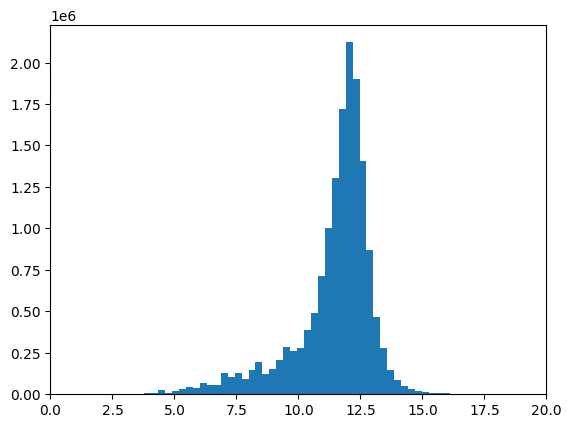

In [11]:
# Creating bins with numpy for faster computations
counts, bin_edges = np.histogram(np.log(df_cleaned['valeurfonc']), bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.xlim([0,20])
plt.show()

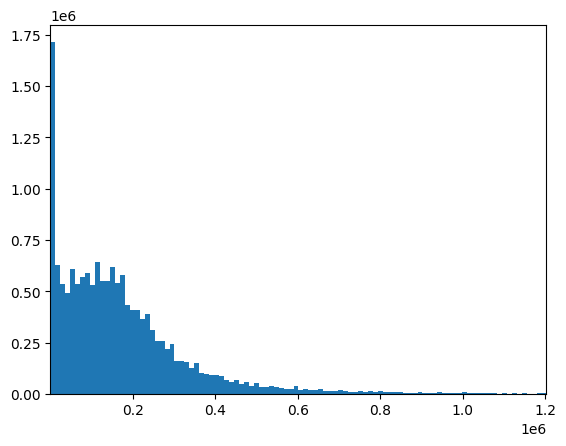

In [12]:
# Creating bins with numpy for faster computations
df_histo = df_cleaned.loc[np.log(df_cleaned['valeurfonc'])<=14]['valeurfonc']
counts, bin_edges = np.histogram(df_histo, bins=100)

# We look at a barplot of the log of valeurfonc to have an idea of the values
plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge')
plt.margins(x=0)
plt.show()

In [13]:
# Since valeurfonc is highly dependant on the size of the building/house sold, we look at price/m2
# We choose to divide first by the built surface (other approches to come)
df_cleaned.loc[:,'p/m2']=df_cleaned['valeurfonc']/df_cleaned['sbati']

In [14]:
# Voir comment utiliser
df_cleaned['libtypbien'].unique()

array(['UNE MAISON', 'TERRAIN DE TYPE TERRE ET PRE',
       'TERRAIN DE TYPE TAB', 'UN APPARTEMENT',
       'TERRAIN NON BATIS INDETERMINE', 'TERRAIN LANDES ET EAUX',
       'TERRAIN FORESTIER', 'DES MAISONS', 'TERRAIN ARTIFICIALISE MIXTE',
       'BATI - INDETERMINE : Vefa sans descriptif', 'ACTIVITE',
       'TERRAIN VITICOLE', 'DES DEPENDANCES', 'BATI MIXTE - LOGEMENTS',
       'BATI - INDETERMINE : Vente avec volume(s)',
       'BATI MIXTE - LOGEMENT/ACTIVITE', "TERRAIN D'AGREMENT",
       'UNE DEPENDANCE', 'APPARTEMENT INDETERMINE',
       'TERRAIN AGRICOLE MIXTE', 'DEUX APPARTEMENTS', 'TERRAIN VERGER',
       "TERRAIN D'EXTRACTION", 'TERRAIN DE TYPE RESEAU',
       'TERRAIN NATUREL MIXTE', 'MAISON - INDETERMINEE'], dtype=object)

## Vizualization

In [15]:
# Geopandas

projections = {
    "Metro":  "EPSG:2154",  # Lambert 93 (France entière hors DOM)
    "971":    "EPSG:5490",  # Guadeloupe (UTM 20N)
    "972":    "EPSG:5490",  # Martinique (UTM 20N)
    "973":    "EPSG:2972",  # Guyane (UTM 22N)
    "974":    "EPSG:2975",  # La Réunion (UTM 40S)
    "976":    "EPSG:4471",   # Mayotte
}

parts = []

#Handling each zones (DOM/TOM have specific zones)
for zone, epsg_code in projections.items():
    if zone == "Metro":
        # Everything that is not a DOM/TOM
        subset = df_cleaned.loc[~((df_cleaned['coddep'].str.startswith('97')) | (df_cleaned['coddep'].isin(['13', '26'])))]
    else:
        # Take specific zone
        subset = df_cleaned.loc[df_cleaned['coddep'] == zone]
    
    if not subset.empty:
        gdf_subset = gpd.GeoDataFrame(
            subset,
            geometry=gpd.points_from_xy(subset['geompar_x'], subset['geompar_y']),
            crs=epsg_code
        )
        
        # Converting to GPS coordinates
        gdf_subset = gdf_subset.to_crs("EPSG:4326")
        
        parts.append(gdf_subset)

gdf_final = pd.concat(parts)



In [16]:
gdf_final['geompar_y'].max()

np.float64(7691163.592435006)

In [17]:
print(gdf_final.geometry.is_empty.sum()) 

0


In [21]:
gdf_final.head()

,anneemut,datemut,valeurfonc,coddep,sbati,sterr,geompar_x,geompar_y,libtypbien,p/m2,geometry
0,2019,2019-11-07,86000.0,79,105.0,157.0,426128.536664,6.630894e+06,UNE MAISON,819.047619,POINT (-0.587 46.72216)
1,2017,2017-03-10,8752.0,79,0.0,29172.0,421354.770938,6.631554e+06,TERRAIN DE TYPE TERRE ET PRE,inf,POINT (-0.64984 46.72612)
2,2021,2021-05-19,15000.0,79,50.0,73.0,454294.454579,6.595390e+06,UNE MAISON,300.000000,POINT (-0.1997 46.41366)
3,2023,2023-05-19,100000.0,79,120.0,2038.0,431277.368041,6.621133e+06,UNE MAISON,833.333333,POINT (-0.51397 46.63644)
5,2024,2024-12-06,182000.0,79,82.0,170.0,434700.127784,6.585247e+06,UNE MAISON,2219.512195,POINT (-0.44879 46.31498)


In [22]:
gdf_final.sample(100).explore()

### Number of transactions per hexagon

In [ ]:

# 1. Configuration
# Note : Résolution 3 est très vaste (échelle régionale). 
# Pour des quartiers, visez plutôt 7, 8 ou 9.
RESOLUTION = 3

# ---------------------------------------------------------
# OPTIMISATION 1 : Calcul des index H3 (Le plus critique)
# ---------------------------------------------------------

# On extrait les colonnes en tableaux NumPy purs (.values)
# C'est beaucoup plus rapide que d'accéder à geometry.x ligne par ligne
lats = gdf_final.geometry.y.values
lons = gdf_final.geometry.x.values

# On utilise une compréhension de liste avec zip
# C'est la méthode standard la plus rapide en Python pur
gdf_final['h3_index'] = [
    h3.latlng_to_cell(lat, lon, RESOLUTION) 
    for lat, lon in zip(lats, lons)
]

# 2. Agréger les données
# Cette étape est nativement optimisée en C par Pandas, rien à changer.
df_counts = gdf_final.groupby('h3_index').size().reset_index(name='Number_transactions')

# ---------------------------------------------------------
# OPTIMISATION 2 : Reconstruction de la géométrie
# ---------------------------------------------------------

def hex_to_poly_optimized(h3_id):
    # cell_to_boundary renvoie ((lat, lon), (lat, lon)...)
    points = h3.cell_to_boundary(h3_id)
    # Inversion (Lat, Lon) -> (Lon, Lat) + Création Polygon
    return Polygon([(lng, lat) for lat, lng in points])

# Ici aussi, on évite .apply() pour utiliser une boucle de liste directe
gdf_h3 = gpd.GeoDataFrame(
    df_counts,
    geometry=[hex_to_poly_optimized(h_id) for h_id in df_counts['h3_index'].values],
    crs="EPSG:4326"
)

# 4. Affichage
m = gdf_h3.explore(
    column="median",
    cmap="inferno",
    style_kwds={"fillOpacity": 0.6, "weight": 0},
    tiles="CartoDB positron"
)
m

### Median price of a transation per hexagon

In [ ]:

# 1. Configuration

resolution = 3

# ---------------------------------------------------------
# Optimization 1 : Assigning an H3 hexagon 
# ---------------------------------------------------------

# On extrait les colonnes en tableaux NumPy purs (.values)
# C'est beaucoup plus rapide que d'accéder à geometry.x ligne par ligne
lats = gdf_final.geometry.y.values
lons = gdf_final.geometry.x.values

# On utilise une compréhension de liste avec zip
# C'est la méthode standard la plus rapide en Python pur
gdf_final['h3_index'] = [
    h3.latlng_to_cell(lat, lon, RESOLUTION) 
    for lat, lon in zip(lats, lons)
]

# 2. Agréger les données
# Cette étape est nativement optimisée en C par Pandas, rien à changer.
df_counts = gdf_final.groupby('h3_index')['valeurfonc'].median().reset_index(name='median')

# ---------------------------------------------------------
# Optimization 2 : Reconstruction de la géométrie
# ---------------------------------------------------------

def hex_to_poly_optimized(h3_id):
    # cell_to_boundary renvoie ((lat, lon), (lat, lon)...)
    points = h3.cell_to_boundary(h3_id)
    # Inversion (Lat, Lon) -> (Lon, Lat) + Création Polygon
    return Polygon([(lng, lat) for lat, lng in points])

# Ici aussi, on évite .apply() pour utiliser une boucle de liste directe
gdf_h3 = gpd.GeoDataFrame(
    df_counts,
    geometry=[hex_to_poly_optimized(h_id) for h_id in df_counts['h3_index'].values],
    crs="EPSG:4326"
)

# 4. Affichage
m = gdf_h3.explore(
    column="median",
    cmap="inferno",
    style_kwds={"fillOpacity": 0.6, "weight": 0},
    tiles="CartoDB positron"
)
m

### Median p/m2 per hexagon

In [ ]:
gdf_final = gdf_final[gdf_final['p/m2'] < np.inf]

In [ ]:

# 1. Configuration
# Note : Résolution 3 est très vaste (échelle régionale). 
# Pour des quartiers, visez plutôt 7, 8 ou 9.
RESOLUTION = 3

# ---------------------------------------------------------
# OPTIMISATION 1 : Calcul des index H3 (Le plus critique)
# ---------------------------------------------------------

# On extrait les colonnes en tableaux NumPy purs (.values)
# C'est beaucoup plus rapide que d'accéder à geometry.x ligne par ligne
lats = gdf_final.geometry.y.values
lons = gdf_final.geometry.x.values

# On utilise une compréhension de liste avec zip
# C'est la méthode standard la plus rapide en Python pur
gdf_final['h3_index'] = [
    h3.latlng_to_cell(lat, lon, RESOLUTION) 
    for lat, lon in zip(lats, lons)
]

# 2. Agréger les données
# Cette étape est nativement optimisée en C par Pandas, rien à changer.
df_counts = gdf_final.groupby('h3_index')['p/m2'].median().reset_index(name='median')

# ---------------------------------------------------------
# OPTIMISATION 2 : Reconstruction de la géométrie
# ---------------------------------------------------------

def hex_to_poly_optimized(h3_id):
    # cell_to_boundary renvoie ((lat, lon), (lat, lon)...)
    points = h3.cell_to_boundary(h3_id)
    # Inversion (Lat, Lon) -> (Lon, Lat) + Création Polygon
    return Polygon([(lng, lat) for lat, lng in points])

# Ici aussi, on évite .apply() pour utiliser une boucle de liste directe
gdf_h3 = gpd.GeoDataFrame(
    df_counts,
    geometry=[hex_to_poly_optimized(h_id) for h_id in df_counts['h3_index'].values],
    crs="EPSG:4326"
)

# 4. Affichage
m = gdf_h3.explore(
    column="median",
    cmap="inferno",
    style_kwds={"fillOpacity": 0.6, "weight": 0},
    tiles="CartoDB positron"
)
m

In [27]:
gdf_h3.head()

,h3_index,median,geometry
0,831840fffffffff,2489,"POLYGON ((-3.74217 47.54858, -4.41084 47.15937..."
1,831844fffffffff,265995,"POLYGON ((-3.24366 48.5473, -3.9234 48.16707, ..."
2,831845fffffffff,468011,"POLYGON ((-2.22661 47.68955, -2.89779 47.31226..."
3,831846fffffffff,87233,"POLYGON ((-4.78997 48.39804, -5.46644 48.00564..."
4,831848fffffffff,31,"POLYGON ((-2.2474 44.82036, -2.88979 44.42867,..."


In [28]:
gdf_final.groupby('h3_index').size().reset_index(name='Number_transactions')

,h3_index,Number_transactions
0,831840fffffffff,2489
1,831844fffffffff,265995
2,831845fffffffff,468011
3,831846fffffffff,87233
4,831848fffffffff,31
...,...,...
89,835f16fffffffff,179
90,835f1efffffffff,396
91,83a250fffffffff,43050
92,83a254fffffffff,16170


## Constructing the required time series, for departments

## Constructing the required time series, for hexagons 

In [31]:
lats = gdf_final.geometry.y.values
lons = gdf_final.geometry.x.values
resolution = 7

gdf_final['h3_index'] = [h3.latlng_to_cell(lat, lon, resolution) for lat, lon in zip(lats, lons)]

In [32]:
gdf_final.head()

,anneemut,datemut,valeurfonc,coddep,sbati,sterr,geompar_x,geompar_y,libtypbien,p/m2,geometry,h3_index
0,2019,2019-11-07,86000.0,79,105.0,157.0,426128.536664,6.630894e+06,UNE MAISON,819.047619,POINT (-0.587 46.72216),83186efffffffff
1,2017,2017-03-10,8752.0,79,0.0,29172.0,421354.770938,6.631554e+06,TERRAIN DE TYPE TERRE ET PRE,inf,POINT (-0.64984 46.72612),83186efffffffff
2,2021,2021-05-19,15000.0,79,50.0,73.0,454294.454579,6.595390e+06,UNE MAISON,300.000000,POINT (-0.1997 46.41366),831868fffffffff
3,2023,2023-05-19,100000.0,79,120.0,2038.0,431277.368041,6.621133e+06,UNE MAISON,833.333333,POINT (-0.51397 46.63644),83186efffffffff
5,2024,2024-12-06,182000.0,79,82.0,170.0,434700.127784,6.585247e+06,UNE MAISON,2219.512195,POINT (-0.44879 46.31498),83186afffffffff


In [35]:
gdf_final.groupby(['h3_index','anneemut'])['p/m2'].median().reset_index(name='median').unstack(1)

h3_index  0       831840fffffffff
          1       831840fffffffff
          2       831840fffffffff
          3       831840fffffffff
          4       831840fffffffff
                       ...       
median    1107        2470.588235
          1108        2615.384615
          1109        2667.307692
          1110        2830.188679
          1111             2750.0
Length: 3336, dtype: object